# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from teren import dir_act_utils as dau
from teren import utils as tu
from transformer_lens import HookedTransformer
from teren.typing import *

device = tu.get_device_str()
print(f"{device=}")

device='cuda'


In [3]:
LAYER = 0
SEQ_LEN = 32
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")

N_PROMPTS = INFERENCE_BATCH_SIZE * 5


input_ids = dau.get_input_ids(chunk=0, seq_len=SEQ_LEN)[:N_PROMPTS]
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

INFERENCE_BATCH_SIZE=400
Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
exctx = dau.ExperimentContext(
    model=model,
    layer=LAYER,
    input_ids=input_ids,
    acts_q_range=(0.01, 0.95),
    batch_size=INFERENCE_BATCH_SIZE,
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
SEED = 0
N_DIRS = 3
BINS = 500
ACTS_Q_RANGE = (0.01, 0.95)

In [6]:
# %% [markdown]
# # directions


# %%
def get_random_dirs(d_model, n_dirs, seed):
    torch.manual_seed(seed)
    dirs = torch.randn((n_dirs, d_model))
    dirs /= dirs.norm(dim=-1, keepdim=True)
    return [dau.Direction(dir, exctx) for dir in dirs]


import random

from sae_lens import SAE

# %%
from teren.saes import SAE_ID_BY_LAYER_BY_FAMILY

sae_family = "gpt2-small-res-jb"
sae_id = SAE_ID_BY_LAYER_BY_FAMILY[sae_family][LAYER]
sae = SAE.from_pretrained(release=sae_family, sae_id=sae_id, device=device)[0]


def get_random_sae_dirs(sae, n_dirs, seed):
    random.seed(seed)
    fids = random.sample(range(sae.cfg.d_sae), n_dirs)
    dirs = sae.W_dec[fids].cpu()
    return [dau.Direction(dir, exctx) for dir in dirs]


# %%
all_svd_dirs = exctx.get_svd_dirs()


def get_random_svd_dirs(n_dirs, seed):
    random.seed(seed)
    idxs = random.sample(range(all_svd_dirs.shape[0]), n_dirs)
    return [dau.Direction(dir, exctx) for dir in all_svd_dirs[idxs]]


# %%
dirs_by_name = {
    "random": get_random_dirs(exctx.d_model, N_DIRS, SEED),
    "sae": get_random_sae_dirs(sae, N_DIRS, SEED),
    "svd": get_random_svd_dirs(N_DIRS, SEED),
}

In [12]:
# %% [markdown]
# # JS dist


# %%
def get_js_dist_by_dir(dirs):
    fracs = torch.tensor([0.0, 1.0])
    return {dir: next(iter(dir.act_fracs_to_js_dists(fracs).values())) for dir in dirs}


# %%
js_dist_by_dir_by_name = {
    name: get_js_dist_by_dir(dirs) for name, dirs in dirs_by_name.items()
}

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
# %%
hist_by_name = {
    name: torch.histogram(
        torch.stack(tuple(js_dist_by_dir.values())), bins=BINS, range=(0, 1)
    )[0].int()
    for name, js_dist_by_dir in js_dist_by_dir_by_name.items()
}

# %%
color_by_name = {
    "sae": "255, 0, 0",
    "random": "0, 255, 0",
    "svd": "0, 0, 255",
}

In [14]:
import numpy as np

# %%
import plotly.graph_objects as go

# Generate sample data
x = np.linspace(0, 1, 100)

# List of tuples (name, color, values)

# Create the figure
fig = go.Figure()

# Add traces for each line and its shaded area
for name, hist in hist_by_name.items():
    color = color_by_name[name]
    line_color = f"rgb({color})"
    shade_color = f"rgba({color}, 0.2)"
    fig.add_trace(
        go.Scatter(
            x=x,
            y=hist / hist.sum(),
            line=dict(color=line_color, width=2),
            name=name,
            fill="tozeroy",  # Fill to y=0
            fillcolor=shade_color,  # Semi-transparent color
        )
    )
# 1% and 95% (layer 0, 10 dirs per type, 64k tokens)
title_params = f"{ACTS_Q_RANGE[0]*100:.0f}% and {ACTS_Q_RANGE[1]*100:.0f}%<br>(layer {LAYER}, {N_DIRS} dirs per type, {N_PROMPTS*SEQ_LEN//1000}k tokens)"

# Update layout
fig.update_layout(
    title=f"distribution of JS distance between activations set to {title_params}",
    xaxis_title="JS distance",
    yaxis_title="density",
    legend_title="dirs type",
)


# Show the plot
fig.show()

In [79]:
name = "sae"
n_prompts = 10
THRESH = 0.5
N_BINS = 15
js_dist_by_dir = js_dist_by_dir_by_name[name]
act_fracs = torch.linspace(0, 1, N_BINS)
js_dist_by_acts_by_dir = {}
for dir, js_dist in js_dist_by_dir.items():
    indices = torch.nonzero(js_dist > THRESH)
    prompt_indices, logits_seq = indices[:n_prompts].T
    print(prompt_indices.shape)
    js_dist_by_acts_by_dir[dir] = dir.act_fracs_to_js_dists(
        act_fracs, prompt_indices, logits_seq
    )

torch.Size([0])
torch.Size([10])
torch.Size([4])


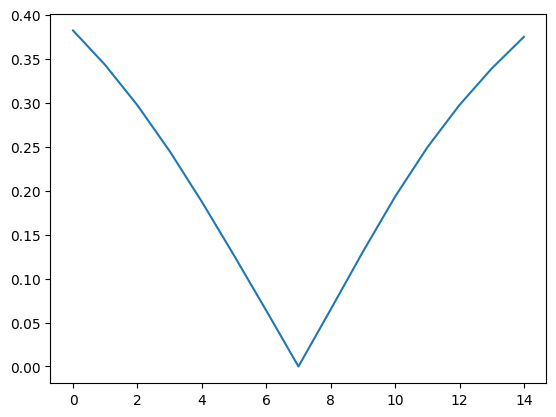

In [88]:
from matplotlib import pyplot as plt


js_dist_by_acts = tuple(js_dist_by_acts_by_dir.values())[1]
j = 6
plt.plot(torch.cat([js_dist_by_acts[i, 7][j : j + 1] for i in range(N_BINS)], dim=1).T)

In [89]:
import math


def helper(mid, i, jsd_by_bin, prev_jsd, auc, min_ratio):
    jsd = jsd_by_bin[mid, i][6].item()
    auc += (jsd + prev_jsd) / 2
    aul = abs(mid - i) * jsd / 2
    min_ratio = min(min_ratio, auc / aul)
    return auc, min_ratio, jsd


def compute_auc_ratio(jsd_by_bin):
    n_bins = int(math.sqrt(len(jsd_by_bin)))
    for mid in range(n_bins):
        min_ratio = float("inf")
        # from mid to left
        auc = prev_jsd = 0
        for i in range(mid - 1, -1, -1):
            auc, min_ratio, prev_jsd = helper(
                mid, i, jsd_by_bin, prev_jsd, auc, min_ratio
            )
        # from mid to right
        auc = prev_jsd = 0
        for i in range(mid + 1, n_bins):
            auc, min_ratio, prev_jsd = helper(
                mid, i, jsd_by_bin, prev_jsd, auc, min_ratio
            )
        print(mid, min_ratio)


compute_auc_ratio(js_dist_by_acts)

0 0.9620578920958864
1 0.975292157676559
2 0.9878021004255854
3 0.9966372459697149
4 1.0
5 1.0
6 0.9987945480347152
7 0.9972395593984371
8 1.0
9 1.0
10 0.9990881149064913
11 0.9855084461515172
12 0.974724650387425
13 0.971372476023505
14 0.9763887154773744
